In [1]:
options(repr.plot.width=8, repr.plot.height=5, jupyter.plot_mimetypes='image/svg+xml')
source('common.r') 
out <- function(obj) write(obj, stdout())

Warning message:
: package ‘ggplot2’ was built under R version 3.2.4

In [2]:
d <- data.rawmix.socc(where="name like 'v6.%'")
out("rows: " + nrow(d))

d$x <- d$threads * num(d$nclients)
d$label <- d$threads #* num(d$nclients) + "x" + d$rate
d$facet <- d$zmix

s <- subset(d, async == 0 
             & rate == 200
             & total_time > 30 & total_time < 32 
            # & (txn_failed < 100 | is.na(txn_failed))
            )
out("rows: " + nrow(s))

The following `from` values were not present in `x`: better#0, better#1
The following `from` values were not present in `x`: better#0, better#1
The following `from` values were not present in `x`: better#0#off#0, better#1#off#0, better#0#on#0, better#1#on#0, redis#0#off#0, redis#0#NA#0


rows: 1203
rows: 594


In [3]:
s.sw <- subset(d, commute_ratio == 0.5 & alpha == 0.6 & rate == 200)
out(nrow(s.sw))

122


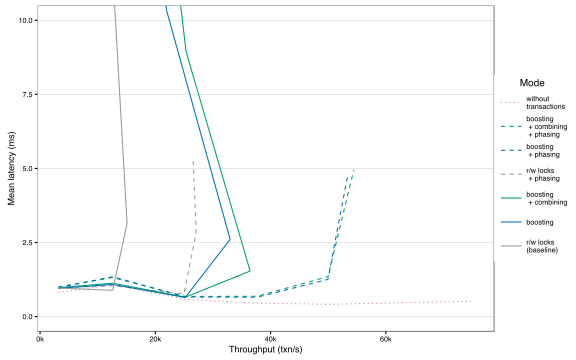

In [16]:
ggplot(s.sw, aes(
    x = throughput,
    y = avg_latency_ms,
    group = cc_ph, fill = cc_ph, color = cc_ph, linetype = cc_ph
))+
  xlab('Throughput (txn/s)')+ylab('Mean latency (ms)')+
  #geom_point()+
#  geom_text(aes(label=label), size=1.7, nudge_y=1.5)+
  # scale_x_continuous(labels=si.labels())+
  scale_x_continuous(labels = function(x){ x/1000+'k' })+
  # geom_point()+
  geom_mean_path(s.sw, throughput, avg_latency_ms, .(x,facet,cc_ph,rate))+
  expand_limits(y=0)+
#   facet_wrap(~facet, scales="free")+
#  facet_grid(rate~facet)+
  # cc_scales()+phasing.linetype()+
  cc_ph_scales()+
  coord_cartesian(ylim=c(0,10))+
  my_theme() #+theme(legend.position='bottom')

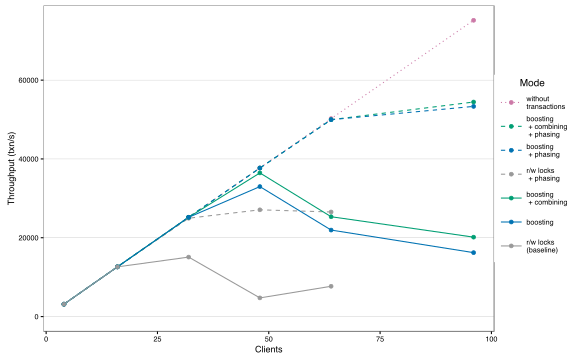

In [5]:
ggplot(s.sw, aes(
    x = threads,
    y = throughput,
    group = cc_ph, fill = cc_ph, color = cc_ph, linetype = cc_ph,
  ))+
  xlab('Clients')+ylab('Throughput (txn/s)')+
  stat_summary(geom='line', fun.y=mean)+
  stat_summary(geom='point', fun.y=mean)+  
  #scale_x_continuous(trans=log2_trans(), breaks=c(16,32,64,128,256,384))+
  expand_limits(y=0)+
  cc_ph_scales()+
  my_theme()

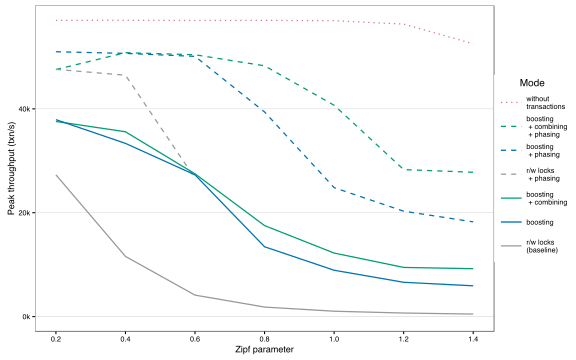

In [14]:
d.zipf <- subset(s, commute_ratio == 0.5 & txn_failed < 200 & name == 'v6.2')

d.zipf.mean <- ddply(d.zipf, .(facet,rate,nthreads,cc_ph,zipf,phasing,cc,timeout_scaling), summarize, throughput=mean(throughput))

ggplot(subset(d.zipf.mean), aes(
    x = num(zipf),
    y = throughput,
    group = cc_ph, fill = cc_ph, color = cc_ph, linetype = cc_ph
))+
  xlab('Zipf parameter')+ylab('Peak throughput (txn/s)')+
  #geom_point(data=d.zipf)+
  stat_summary(geom='line', fun.y=max, size=0.6)+
  #stat_summary(geom='point', fun.y=max)+
  # geom_text(size=1.2)+
  expand_limits(y=0)+
  scale_x_continuous(breaks=c(0.2,0.4,0.6,0.8,1.0,1.2,1.4))+
  # scale_y_continuous(labels=si.labels())+
  scale_y_continuous(labels=function(x){ x/1000+'k' })+
  # facet_wrap(~facet, ncol=6)+ #, scales="free")+
  # cc_scales(title='Mode:', guide = guide_legend(nrow = 3))+
  # color_scales('', my_palette)+
  # phasing.linetype(title='Phasing:', guide = guide_legend(nrow = 2))+
  cc_ph_scales()+
  my_theme() #+legend.bottom()

Warning message:
: Removed 25 rows containing missing values (geom_errorbar).

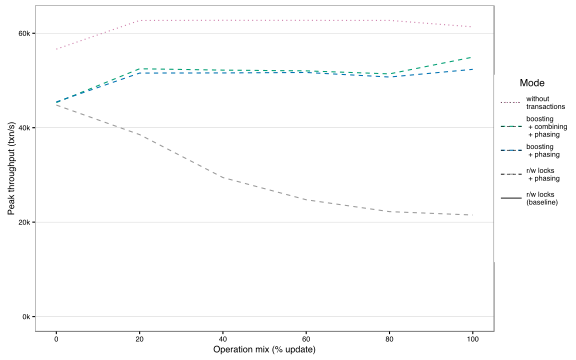

In [10]:

d.mix <- subset(s, zipf == 0.6 & txn_failed < 100 & commute_ratio != 0.5)

d.mix.mean <- ddply(d.mix, .(facet,rate,nthreads,cc_ph,zipf,commute_ratio,phasing,cc,timeout_scaling), summarize, throughput=mean(throughput), op_timeouts=mean(op_timeouts))

ggplot(subset.modes(subset(d.mix.mean)), aes(
    x = num(commute_ratio)*100,
    y = throughput,
    group = cc_ph, fill = cc_ph, color = cc_ph, linetype = cc_ph
  ))+
  xlab('Operation mix (% update)')+ylab('Peak throughput (txn/s)')+
  stat_summary(geom='line', fun.y=max)+
  #stat_summary(geom='point', fun.y=max)+
  stat_summary(fun.data=mean_cl_normal, geom='errorbar', size=0.3, width=0.2, color='black')+
  #geom_point(data=d.mix)+
  # stat_summary(geom='text', fun.y=max, size=1.2)+
  expand_limits(y=0)+
  scale_x_continuous(breaks=c(0,20,40,60,80,100))+
  scale_y_continuous(labels=function(x){ x/1000+'k' })+
  # color_scales('', my_palette)+
  # cc_scales(title='Mode:', guide = guide_legend(nrow = 3))+
  # phasing.linetype(guide = guide_legend(nrow = 2))+
  cc_ph_scales()+
  my_theme()

In [17]:
d <- data.rawmix(where="name like 'v0.28.1%' and nclients = 4 and duration = 30 and length = 4 and rate = 100 and total_time < 61")
    
    d <- subset(d, commute_ratio == 0.5 & alpha == 0.6)

The following `from` values were not present in `x`: redis#0#off#0


In [18]:
d$label <- d$nthreads * num(d$nclients) + "x" + d$rate

d$x <- d$nthreads * num(d$nclients)

g.cc_ph <- guide_legend(nrow = 6)

# force all non-transactional ones to be considered 'rw' mode (messes up some groupings otherwise)
d[d$cc_ph == NOTXN,]$cc <- RW

# subset to just my selected set of lines
d <- subset(d, cc_ph %in% c(RW+BASE, COMM, COMM+PH, COMB+PH, NOTXN))


In [25]:
d$facet

NULL

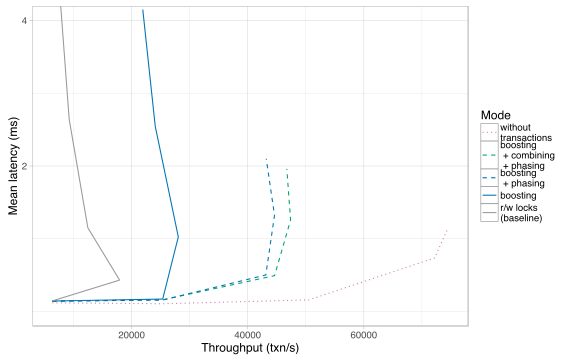

In [26]:
  ggplot(d, aes(
    x = throughput,
    y = avg_latency_ms,
    group = cc_ph, fill = cc_ph, color = cc_ph, linetype = cc_ph
  ))+
  xlab('Throughput (txn/s)')+ylab('Mean latency (ms)')+
  geom_mean_path(d, throughput, avg_latency_ms, .(x,cc_ph,rate))+
  expand_limits(y=0)+
  coord_cartesian(ylim=c(0,4))+
  scale_y_continuous(breaks=c(2,4,6,8,10,12))+
  cc_ph_scales(guide = guide_legend(nrow=5))+
  theme.mine()+
  theme(
    panel.grid.major.x = element_line(color="grey80", size=0.2),
    panel.grid.minor.x = element_line(color="grey90", size=0.2),
    panel.grid.minor.y = element_line(color="grey90", size=0.2)
  )
